# 1. Candidate generation

In [31]:
import pandas as pd 
import numpy as np
import random


***Read Files***

In [32]:
df = pd.read_csv('data/user_videos_updated.csv')
df = df.dropna()
df.count()


user_id               1476
user_gender           1476
user_zip              1476
dwell_time            1476
watchedAt             1476
                      ... 
discussion_density    1476
like_percentage       1476
dislike_percentage    1476
like_dislike_ratio    1476
share_percentage      1476
Length: 120, dtype: int64

In [33]:
# map user id with indexb

userMap = {v:k for k,v in enumerate(df['user_id'].unique())}
videoMap = {v:k for k,v in enumerate(df['video_id'].unique())}
df['user_id'] = df['user_id'].map(userMap)
df['video_id'] = df['video_id'].map(videoMap)
df['example_age']=(pd.to_datetime("now")-pd.to_datetime(df['publishedAt']).dt.tz_localize(None))/ np.timedelta64(1,'D')

In [34]:
def normalize_col(df,col_name):
    df[col_name] = (df[col_name] - df[col_name].mean()) / (df[col_name].std() + 1e-10)
    return df

In [35]:
df['like/dislike'] = [True if x >=0.5 else False for _,x in enumerate(df['like_dislike_ratio'].tolist())]
df = normalize_col(df,'example_age')
df = normalize_col(df,'dwell_time')

In [36]:
users = df.iloc[:,:3]
videos = df.iloc[:,7:]

In [37]:
videos['year'] = videos['publishedAt'].apply(lambda x:str(x).split('-')[0])


In [38]:
watch_cols = ['user_id', 'video_id','dwell_time','like/dislike','watchedAt']
watch = df[watch_cols]
watch['year'] = watch['watchedAt'].apply(lambda x:str(x).split('-')[0])
watch = normalize_col(watch,'dwell_time')

c:\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [39]:
# like & dislike both false -> like
# like & dislike both true -> random false
watch['like/dislike'] = df['like/dislike']
watch['like/dislike'].unique()

array([ True, False])

In [40]:
# genres encoding
genres = df['category_term'].unique().tolist()
genres_encoded = {x: i for i,x in enumerate(genres)}
genres_encoded_2_genres = {i:x for i,x in enumerate(genres)}


# user encoding
user_ids = users['user_id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# movie index encoding
video_ids = videos["video_id"].unique().tolist()
video2video_encoded = {x: i for i, x in enumerate(video_ids)}
video_encoded2video = {i: x for i, x in enumerate(video_ids)}

# movie title encoding
title_ids = videos['video_title'].unique().tolist()
title2title_encoded = {x: i for i, x in enumerate(title_ids)}
title_encoded2title = {i: x for i, x in enumerate(title_ids)}

#video category encoding 
cats = videos['category_term'].unique().tolist()
cat2cat_encoded = {x: i for i,x in enumerate(cats)}
cat_encoded2cat = {x:i for x,i in enumerate(cats)}

# genders encoding
gender_ids = users['user_gender'].unique().tolist()
gender2gender_encoded = {x: i for i, x in enumerate(gender_ids)}
gender_encoded2gender = {i: x for i, x in enumerate(gender_ids)}

#like/disklike encoding
like_dislike_ids =  watch['like/dislike'].unique().tolist()
like_dislike_ids2encoded = {x: i for i, x in enumerate(like_dislike_ids)}
encoded2like = {i: x for i, x in enumerate(like_dislike_ids)}




In [41]:
# # Only do this one time
likeMap = {True:'like', False:'dislike'}
df['like/dislike'] = df['like/dislike'].map(likeMap)

In [42]:

dfenc = df
# Change to encoding
dfenc["title_id"] = df["video_title"].map(title2title_encoded)

dfenc["user"] = df["user_id"].map(user2user_encoded)
dfenc["video"] = df["video_id"].map(video2video_encoded)
dfenc["title_d"] = df["video_title"].map(title2title_encoded)
dfenc['gender_d'] = df['user_gender'].map(gender2gender_encoded)
dfenc['cat_d'] = df['category_term'].map(cat2cat_encoded)

watch_hist = dfenc.groupby(['user'])['video_id'].apply(list).reset_index()

watch_hist_time = dfenc.groupby(['user'])['dwell_time'].apply(list).reset_index()

like_dislike = dfenc.groupby(['user','like/dislike'])['video'].apply(list).reset_index()

example_age = dfenc.groupby(['user'])['example_age'].apply(list).reset_index()


user_video_fond = like_dislike.pivot(index='user', columns='like/dislike', values='video').reset_index()
user_video_fond.fillna(dfenc["video"].max()+1, inplace=True)
user_video_fond['dislike'] = user_video_fond['dislike'].apply(lambda x: ([x])) 

user_video_list = dfenc.pivot(index='user_id', columns='video_id', values='video').reset_index()
user_video_list.fillna(dfenc["video_id"].max()+1, inplace=True)

sample_data=dfenc[['user','user_gender']]
# sample_data=sample_data.reset_index()
sample_data = sample_data.drop_duplicates()

user_movie_list = pd.merge(sample_data,watch_hist, how= 'left')
user_movie_list = pd.merge(user_movie_list,watch_hist_time, how='left')
user_movie_list = pd.merge(user_movie_list,example_age, how='left')
user_movie_list = pd.merge(user_movie_list,user_video_fond,how='left')
user_movie_list['predict_labels'] = user_movie_list['video_id'].apply(lambda x: int(random.uniform(0,dfenc["video"].max()))) #label을 마지막 값으로..


# split 60:40
# train_size = user_movie_list.user.max() * 0.6
# # train_size = 10 * 0.6
# test_size = user_movie_list.user.max() - train_size
# train_data = user_movie_list[(user_movie_list.user >= 1)&
#                                   (user_movie_list.user <= tr)]
# test_data = user_movie_list[(user_movie_list.user >= train_size+1)&
#                                   (user_movie_list.user <= 10)]

In [43]:
# user_movie_list['predict_labels'] = user_movie_list['like'].apply(lambda x: (x[-1]) )
# user_movie_list['like'] = user_movie_list['like'].apply(lambda x: x[:-1])

In [44]:
# split test and train set
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(user_movie_list, test_size=0.2)


In [45]:
test_data

,user,user_gender,video_id,dwell_time,example_age,dislike,like,predict_labels
27,27,Female,"[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[0.24767522290450272, 1.7209538503971737, -0.3...","[2.907296769590771, -0.14531180094608698, 1.23...",[[190]],"[188, 189, 191, 192, 193, 194, 195, 196, 197, ...",963
39,39,Male,"[280, 281, 282, 283, 284, 285, 286, 287, 288, ...","[-0.08002464105895077, -0.07620414050243829, -...","[0.19858036604241905, 1.2010559894159276, 1.17...",[1435],"[280, 281, 282, 283, 284, 285, 286, 287, 288, ...",1279
28,28,Male,"[211, 212, 2, 213, 214]","[-0.3076194880539917, 0.27116659028818196, 13....","[2.0565529400473963, 1.4186129155636424, -0.74...",[1435],"[211, 212, 2, 213, 214]",890
64,64,Female,"[448, 449, 450, 451, 452]","[0.058221554496315366, -0.4711138125853509, -0...","[-0.877289646227569, 1.3203024851849456, 1.571...",[1435],"[448, 449, 450, 451, 452]",569
46,46,Female,[328],[-0.3877010701247876],[1.8964597533623675],[1435],[328],1193
78,78,Male,"[557, 558, 559, 560, 561, 562, 563, 564, 565, ...","[1.642568242320438, 0.1390569027866936, -0.536...","[-0.6230382475960605, -0.9208336164950901, 1.7...",[1435],"[557, 558, 559, 560, 561, 562, 563, 564, 565, ...",1286
53,53,Female,"[376, 377, 378]","[-0.30483237666948737, -0.6750258112618993, -0...","[-0.5874282592941822, -0.037882343451402185, -...",[1435],"[376, 377, 378]",161
36,36,Female,"[270, 271, 272]","[-0.26670335560230446, 0.41552801823780217, 0....","[-0.8604225160819063, -0.7739986456268224, -0....",[1435],"[270, 271, 272]",1126
85,85,Male,"[667, 668]","[-0.3681730541537513, -0.6705366471234993]","[-0.339029494746209, 0.544851226524159]",[1435],"[667, 668]",830
80,80,Male,"[603, 604, 605, 606]","[-0.6153475865784289, -0.35083339172343814, -0...","[0.2669779600238575, 1.3510923831489001, 0.227...",[1435],"[603, 604, 605, 606]",1385


### Hyperparameter Definition

In [46]:
# CONTINUE FROM HERE - 30-09-2021
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES= df["video_id"].max() + 2
LEARNING_RATE = 0.003

In [47]:

import tensorflow as tf
tf.random.set_seed(
    1024
)
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
#         https://www.tensorflow.org/api_docs/python/tf/ragged/boolean_mask
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [66]:
#---inputs
import tensorflow as tf
import datetime
import os
input_watch_hist = tf.keras.Input(shape=(None, ), name='watch_hist')
input_dwell_time = tf.keras.layers.Input(shape=(None,), name='dwell_time')
input_like = tf.keras.layers.Input(shape=(None,), name='like')
input_example_age = tf.keras.Input(shape=(None, ), name='example_age')
# input_occupation = tf.keras.Input(shape=(None, ), name='occupation')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

#--- features
features_embeddings = features_embedding_layer(input_watch_hist)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_watch_embeddings = labels_embedding_layer(input_dwell_time)
l2_norm_watched = l2_norm_1(labels_watch_embeddings)
avg_watched = avg_embeddings(l2_norm_watched)

labels_like_embeddings = labels_embedding_layer(input_like)
l2_norm_like = l2_norm_1(labels_like_embeddings)
avg_liked = avg_embeddings(l2_norm_like)

labels_example_age_embeddings = labels_embedding_layer(input_example_age)
l2_norm_example_age = l2_norm_1(labels_example_age_embeddings)
avg_example_age = avg_embeddings(l2_norm_example_age)

# labels_occupation_embeddings = labels_embedding_layer(input_occupation)
# l2_norm_occupation = l2_norm_1(labels_occupation_embeddings)
# avg__occupation = avg_embeddings(l2_norm_occupation)


print(avg_features)
print(avg_watched)
print(avg_liked)
print(avg_example_age)
# print(input_occupation)

# 임베딩 벡터들 연결
concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_features,
                                                     avg_watched,
                                                     avg_liked,
                                                     avg_example_age,
#                                                      avg__occupation
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
# for ranking we use this line
# outputs = dense_output(dense_3_batch_norm) + tf.keras.layers.Softmax(dense_3_batch_norm)
# for canndidate generation
outputs = dense_output(dense_3_batch_norm)


#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_watch_hist, 
            input_dwell_time, 
            input_like,
            input_example_age,
#             input_occupation,
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
et = tf.keras.callbacks.EarlyStopping(
    monitor="acc",
    #min_delta=0,
    patience=50,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# đổi tử sparse -> categorical:
# đổi predict labels từ scalar (1 int) -> one hot encoding.
# vd [1],[2],[3] -> [100],[010], [001]

model.compile(optimizer=optimiser, loss = lambda y_pred,y_true: tf.keras.losses.CategoricalCrossentropy()(tf.keras.layers.Softmax(y_pred), y) )
# model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_hist (InputLayer)         [(None, None)]       

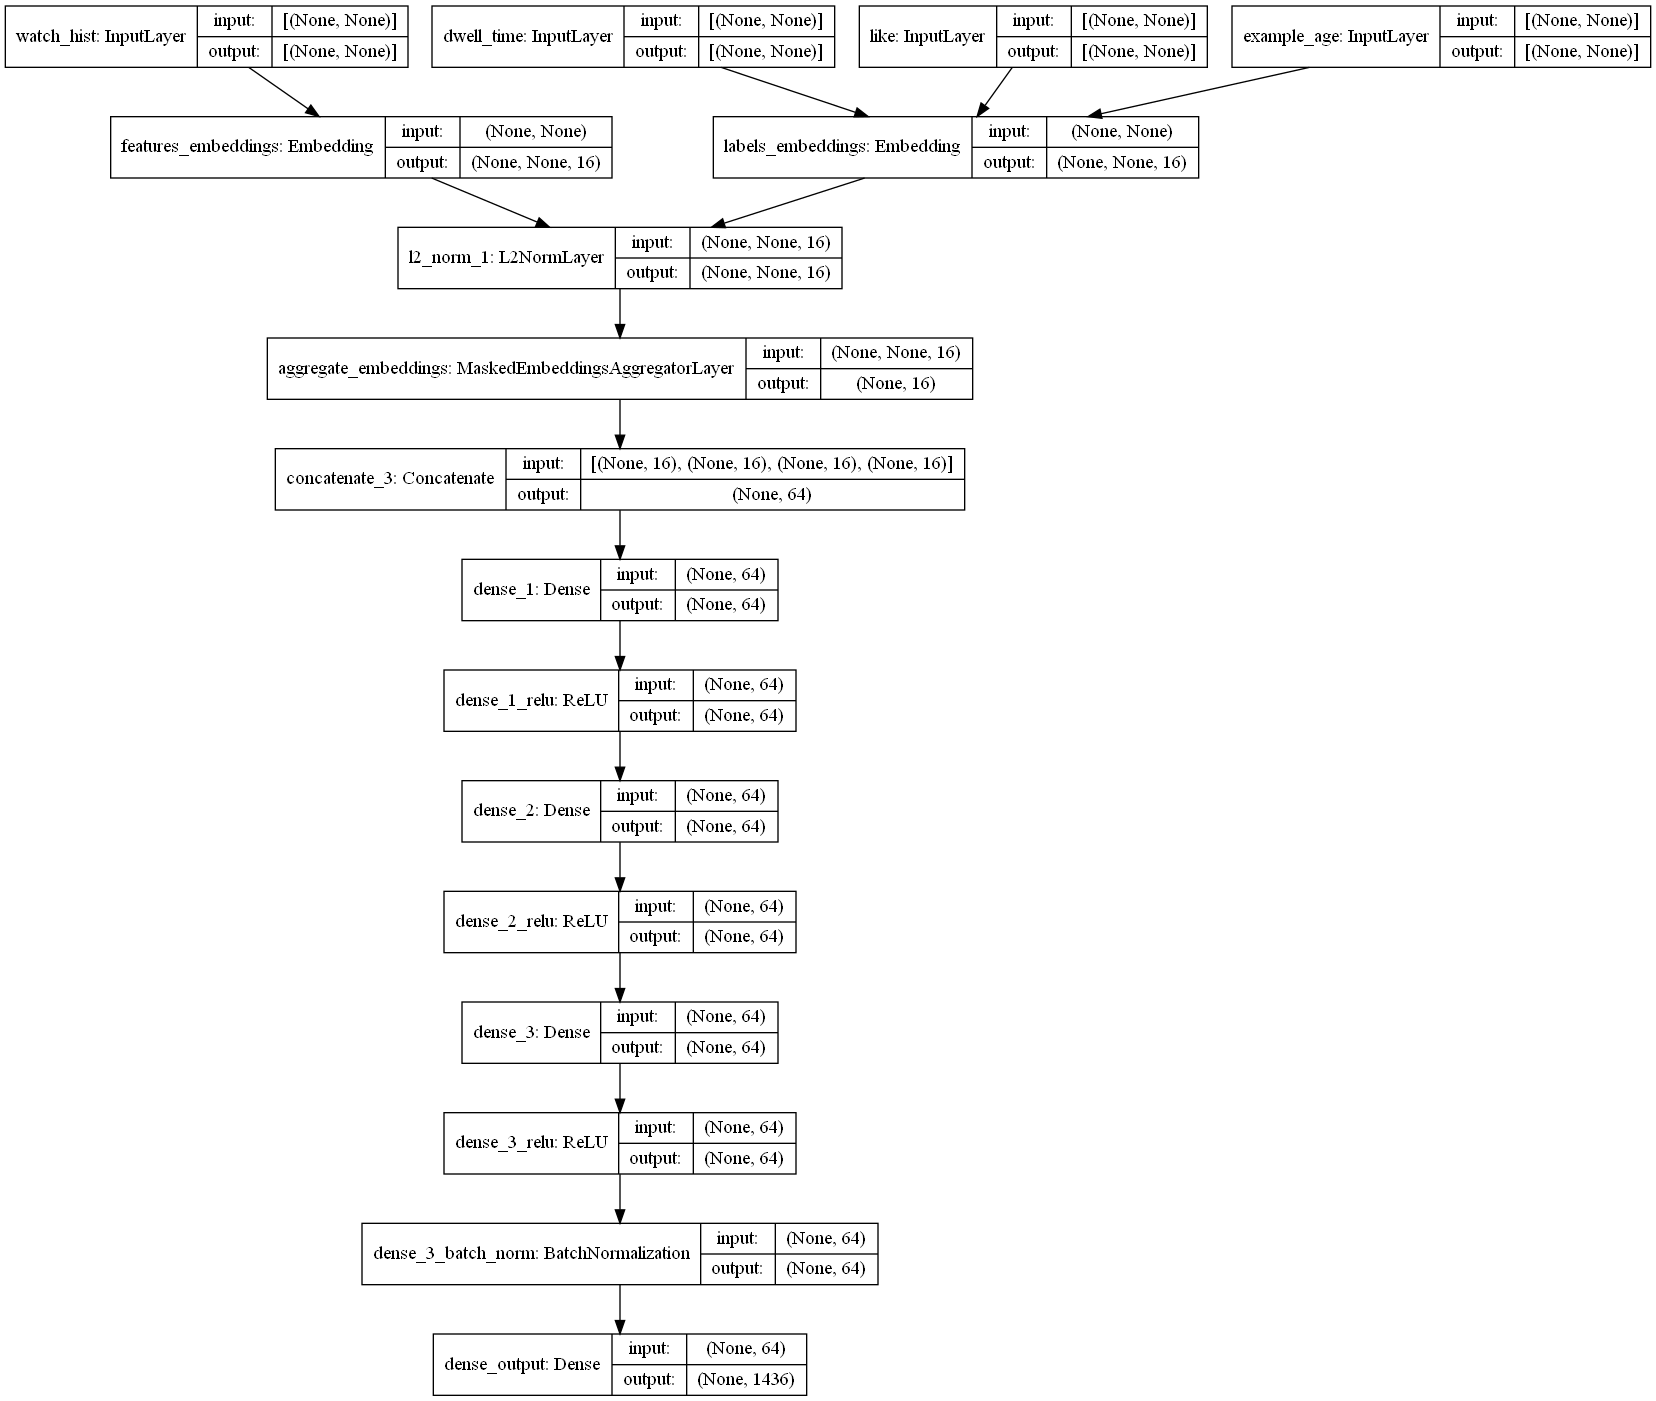

In [67]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [50]:
type(train_data)

pandas.core.frame.DataFrame

In [51]:
train_data

,user,user_gender,video_id,dwell_time,example_age,dislike,like,predict_labels
117,117,Female,"[1066, 1067, 1068, 1069]","[-0.23120339816390706, -0.655470440871604, -0....","[-0.7527891343656518, -0.7572088549693059, -0....",[1435],"[1066, 1067, 1068, 1069]",529
140,140,Female,"[1315, 1316, 1317, 1318, 1319, 1320, 1321, 132...","[-0.6063540614020403, -0.34893073989497614, -0...","[-0.02957019584178605, 0.5484769724102546, -0....",[1435],"[1315, 1316, 1317, 1318, 1319, 1320, 1321, 132...",95
87,87,Female,"[670, 671, 672, 673, 674, 675, 676, 677, 678, ...","[-0.10416643574501168, 0.11302765317175914, -0...","[0.300712095372552, 0.22058146026222542, 0.198...",[1435],"[670, 671, 672, 673, 674, 675, 676, 677, 678, ...",475
60,60,Female,"[419, 420, 421]","[-0.5743676271484706, 0.5630595194415531, -0.4...","[0.26457138647512285, 0.5889561713527057, -0.8...",[1435],"[419, 420, 421]",657
86,86,Female,[669],[1.4035270905554482],[-0.2173001211792478],[1435],[669],460
...,...,...,...,...,...,...,...,...
113,113,Female,"[986, 987, 988, 989]","[-0.23003323689560368, 0.02024754180493371, -0...","[-0.856796288274237, 0.8942854380662612, 1.926...",[1435],"[986, 987, 988, 989]",1104
70,70,Male,"[507, 508]","[0.04351703445462293, 0.3073504082080555]","[0.4039471752217729, -0.677667395756555]",[1435],"[507, 508]",718
100,100,Female,"[475, 806, 807, 808, 809]","[0.013363346291408819, -0.5636082222399152, 0....","[-0.8815251478473434, -0.7489613383974405, -0....",[1435],"[475, 806, 807, 808, 809]",937
114,114,Male,"[328, 990, 991, 992, 993, 994, 995]","[-0.14992430040554874, -0.4978755527604442, -0...","[1.8964597533623675, -0.25123111256642744, 0.4...",[1435],"[328, 990, 991, 992, 993, 994, 995]",652


In [52]:
history = model.fit([tf.keras.preprocessing.sequence.pad_sequences(train_data['video_id']),
           tf.keras.preprocessing.sequence.pad_sequences(train_data['dwell_time'], dtype=float),
           tf.keras.preprocessing.sequence.pad_sequences(train_data['like']) + 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(train_data['example_age'], dtype=float),
#            tf.keras.preprocessing.sequence.pad_sequences(train_data['occupation'], dtype=float),
           ],train_data['predict_labels'].values,
           steps_per_epoch=1, epochs=5000,callbacks=[et])




Epoch 1/5000
1/1 [==============================] - 1s 1s/step - loss: 7.2587 - acc: 0.0000e+00
Epoch 2/5000
1/1 [==============================] - 0s 13ms/step - loss: 7.1844 - acc: 0.0254
Epoch 3/5000
1/1 [==============================] - 0s 11ms/step - loss: 7.1003 - acc: 0.0763
Epoch 4/5000
1/1 [==============================] - 0s 12ms/step - loss: 7.0102 - acc: 0.1102
Epoch 5/5000
1/1 [==============================] - 0s 10ms/step - loss: 6.9116 - acc: 0.1271
Epoch 6/5000
1/1 [==============================] - 0s 10ms/step - loss: 6.8067 - acc: 0.1525
Epoch 7/5000
1/1 [==============================] - 0s 10ms/step - loss: 6.6950 - acc: 0.1356
Epoch 8/5000
1/1 [==============================] - 0s 10ms/step - loss: 6.5786 - acc: 0.1610
Epoch 9/5000
1/1 [==============================] - 0s 10ms/step - loss: 6.4593 - acc: 0.1610
Epoch 10/5000
1/1 [==============================] - 0s 10ms/step - loss: 6.3382 - acc: 0.1695
Epoch 11/5000
1/1 [==============================] - 0s 1

In [61]:
model.save("candidate_generation.h5")

c:\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [62]:
pred = model.predict([tf.keras.preprocessing.sequence.pad_sequences(test_data['video_id']),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['dwell_time'], dtype=float),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['like']),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['example_age'], dtype=float)
           ])

In [63]:
pred

array([[0.00027085, 0.0002881 , 0.00027902, ..., 0.00027816, 0.00024139,
        0.00024188],
       [0.00026106, 0.00027848, 0.00026446, ..., 0.00026985, 0.00022975,
        0.00023458],
       [0.00026106, 0.00027848, 0.00026446, ..., 0.00026985, 0.00022975,
        0.00023458],
       ...,
       [0.00040858, 0.0004315 , 0.00038506, ..., 0.00034968, 0.00034909,
        0.00035159],
       [0.00045106, 0.00048484, 0.00042133, ..., 0.00037162, 0.00036275,
        0.0004023 ],
       [0.00027094, 0.00028695, 0.00027778, ..., 0.00028027, 0.00024205,
        0.00024596]], dtype=float32)

In [64]:
# candidate generation: 
###### We extract the top-7 recommendation data for each user.
N = 6
k = np.sort((-pred).argsort()[:,:N])
print(k)
k = k.flatten()
k[k>df["video"].max()]=0
k = np.unique(k)


[[ 274  825  956 1174 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [ 274  825 1174 1309 1322 1345]
 [  34   87  187  940 1151 1339]
 [  34  187  503  925  940 1104]
 [ 187  197  503  718  925 1104]
 [ 164  274  825 1174 1322 1345]]


In [57]:
k

array([  34,   87,  164,  187,  197,  274,  503,  718,  825,  925,  940,
        956, 1104, 1151, 1174, 1309, 1322, 1339, 1345], dtype=int64)

# 2. Ranking

### Load dmodel and preprocess data

In [58]:
model = tf.keras.models.load_model(
    'candidate_generation.h5',
    custom_objects={
        'L2NormLayer': L2NormLayer,
        "MaskedEmbeddingsAggregatorLayer": MaskedEmbeddingsAggregatorLayer
    }
)

# custom_object: not available in tensorflow 

In [59]:
def get_genres(movies, genres):
    def get_all_genres(gs):
        active = [str(genres_encoded[genre]) for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return '0'
        return ','.join((active))
    movies['all_genres'] = [
    get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]


In [60]:
train_data

,user,user_gender,video_id,dwell_time,example_age,dislike,like,predict_labels
117,117,Female,"[1066, 1067, 1068, 1069]","[-0.23120339816390706, -0.655470440871604, -0....","[-0.7527891343656518, -0.7572088549693059, -0....",[1435],"[1066, 1067, 1068, 1069]",529
140,140,Female,"[1315, 1316, 1317, 1318, 1319, 1320, 1321, 132...","[-0.6063540614020403, -0.34893073989497614, -0...","[-0.02957019584178605, 0.5484769724102546, -0....",[1435],"[1315, 1316, 1317, 1318, 1319, 1320, 1321, 132...",95
87,87,Female,"[670, 671, 672, 673, 674, 675, 676, 677, 678, ...","[-0.10416643574501168, 0.11302765317175914, -0...","[0.300712095372552, 0.22058146026222542, 0.198...",[1435],"[670, 671, 672, 673, 674, 675, 676, 677, 678, ...",475
60,60,Female,"[419, 420, 421]","[-0.5743676271484706, 0.5630595194415531, -0.4...","[0.26457138647512285, 0.5889561713527057, -0.8...",[1435],"[419, 420, 421]",657
86,86,Female,[669],[1.4035270905554482],[-0.2173001211792478],[1435],[669],460
...,...,...,...,...,...,...,...,...
113,113,Female,"[986, 987, 988, 989]","[-0.23003323689560368, 0.02024754180493371, -0...","[-0.856796288274237, 0.8942854380662612, 1.926...",[1435],"[986, 987, 988, 989]",1104
70,70,Male,"[507, 508]","[0.04351703445462293, 0.3073504082080555]","[0.4039471752217729, -0.677667395756555]",[1435],"[507, 508]",718
100,100,Female,"[475, 806, 807, 808, 809]","[0.013363346291408819, -0.5636082222399152, 0....","[-0.8815251478473434, -0.7489613383974405, -0....",[1435],"[475, 806, 807, 808, 809]",937
114,114,Male,"[328, 990, 991, 992, 993, 994, 995]","[-0.14992430040554874, -0.4978755527604442, -0...","[1.8964597533623675, -0.25123111256642744, 0.4...",[1435],"[328, 990, 991, 992, 993, 994, 995]",652
